# Building a simple NN from scratch with numPy

Implement the missing functionalities one by one.

In [41]:
from os.path import join
import random

import numpy as np

from dreader import MnistDataloader, show_images


## Data Import (Given)

We use the MNIST dataset, it contains 28x28 images of handwritten digits, we want to classify. The training data contains 60k images, the test dataset contains 10k.

In [42]:
DATA_PATH = "../data/mnist/"

# paths
training_images_filepath = join(
    DATA_PATH, "train-images-idx3-ubyte/train-images-idx3-ubyte"
)
training_labels_filepath = join(
    DATA_PATH, "train-labels-idx1-ubyte/train-labels-idx1-ubyte"
)
test_images_filepath = join(DATA_PATH, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels_filepath = join(DATA_PATH, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

mnist_dataloader = MnistDataloader(
    training_images_filepath,
    training_labels_filepath,
    test_images_filepath,
    test_labels_filepath,
)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

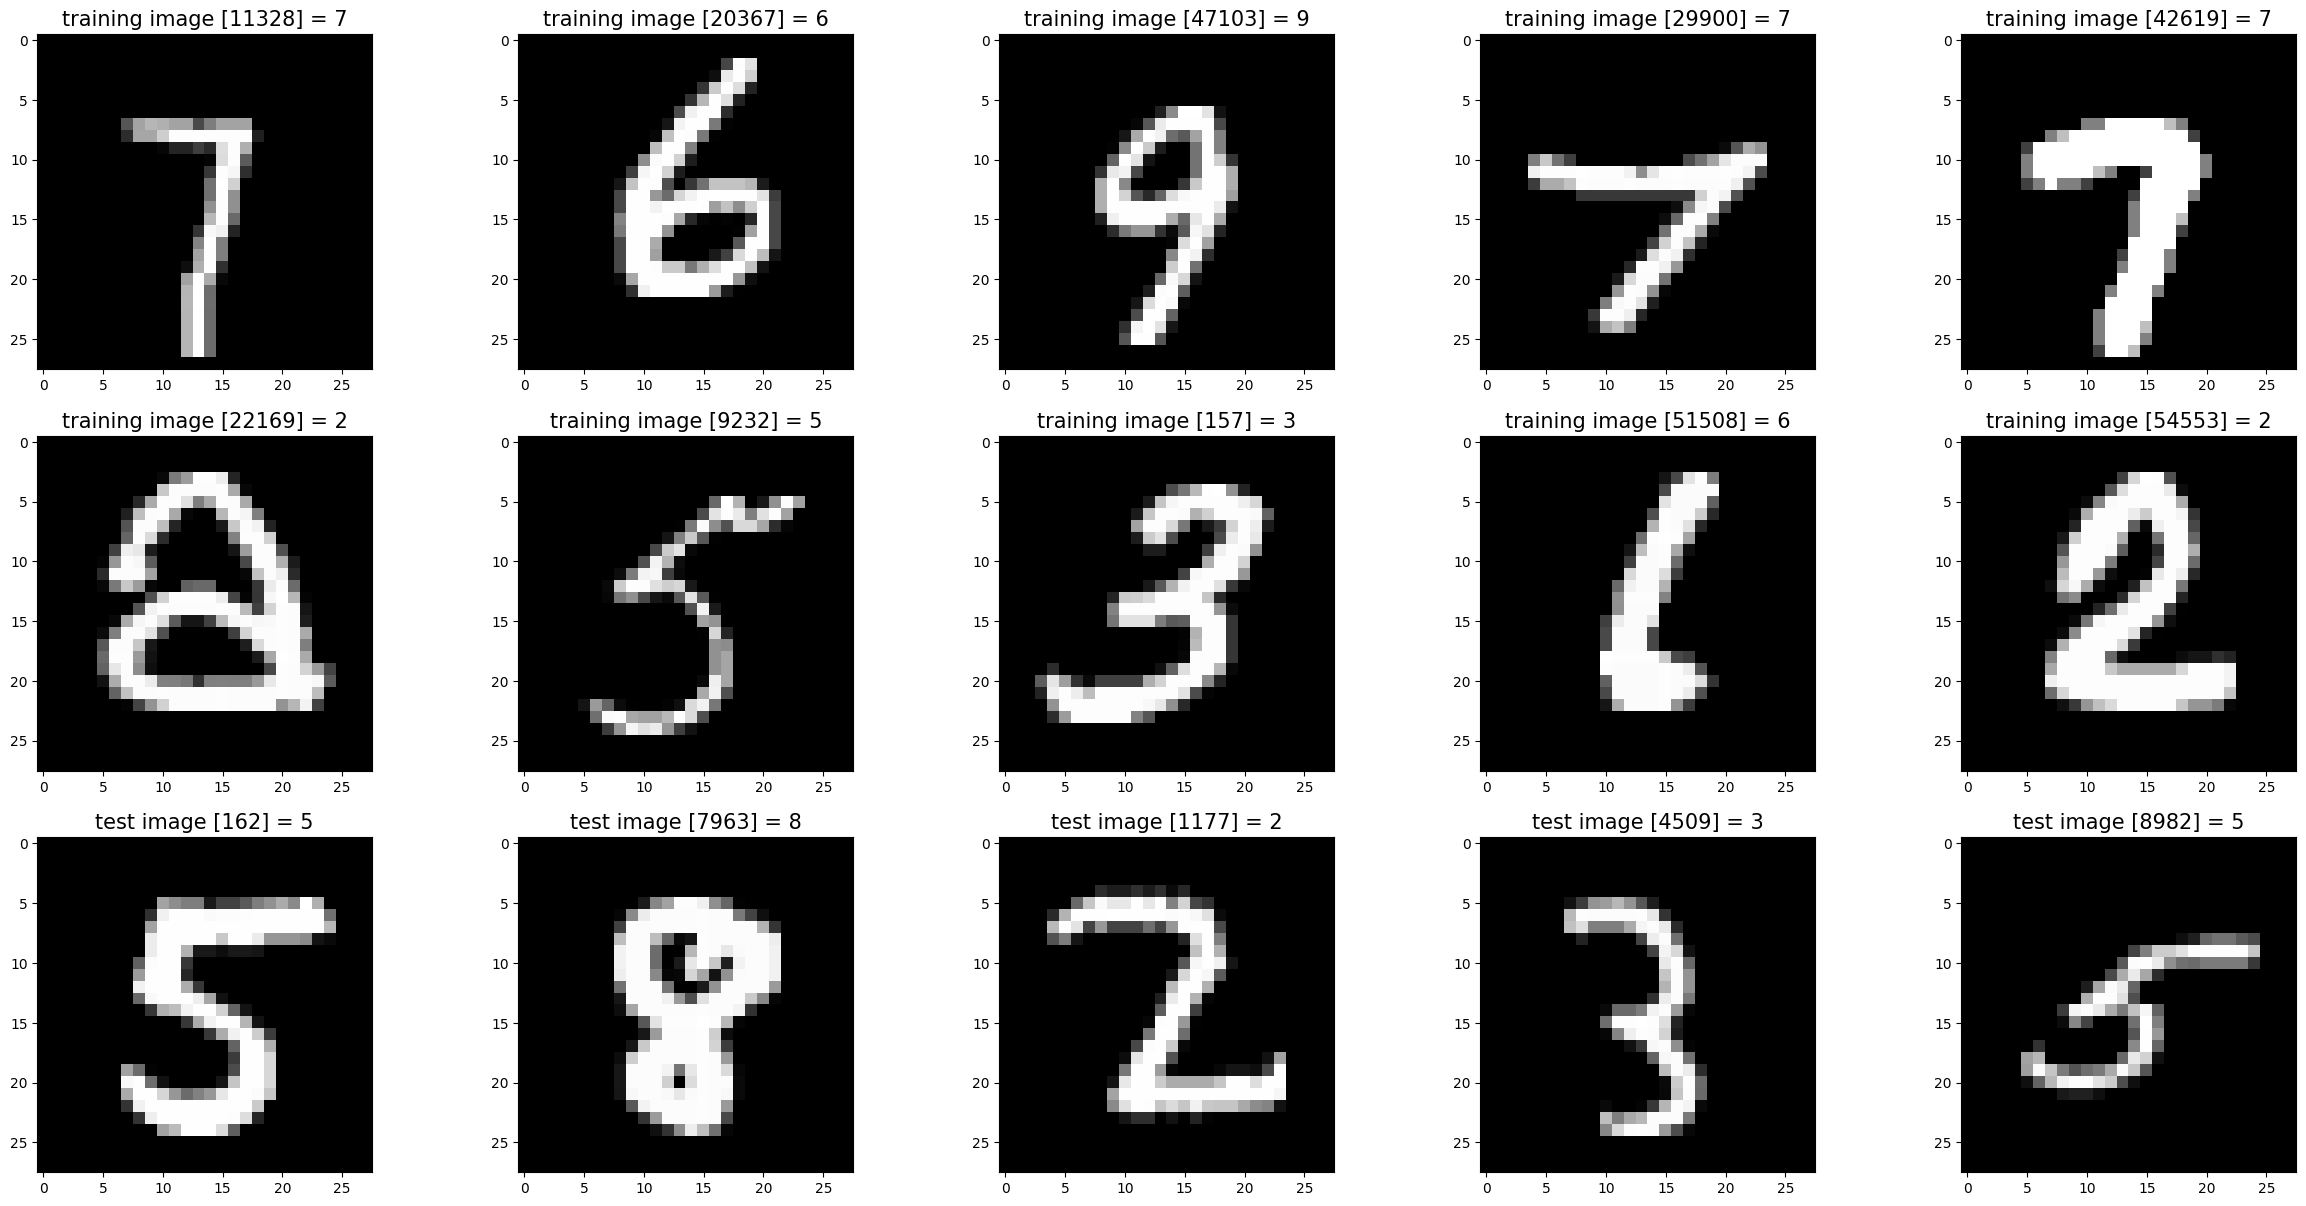

In [43]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append("training image [" + str(r) + "] = " + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append("test image [" + str(r) + "] = " + str(y_test[r]))

show_images(images_2_show, titles_2_show)

## Transform Data for Numpy

In [59]:
# TBD: convert data into numpy arrays and normalize values between to 0-1 (currently its 0-255) (x = image array, y = label)
TRAINING_SIZE = 60000  # max 60000

x_train = np.array(x_train)[:TRAINING_SIZE] / 255
y_train = np.array(y_train)[:TRAINING_SIZE]
x_test = np.array(x_test) / 255
y_test = np.array(y_test)

x_train.shape

(60000,)

## Setup the Network

Complete the function init_params to return the arrays, defining the tunable parameters (weights W, biases b per layer).
We will build a network with two trainable layers of size 10 each. What is the size of the input layer?

In [45]:
input_size = x_train.shape[1] * x_train.shape[2]

# transform the data into 2D arrays with 28*28=784 pixels
x_train = x_train.reshape(x_train.shape[0], input_size)
x_test = x_test.reshape(x_test.shape[0], input_size)

def init_params():
    W1 = np.random.rand(10, input_size) - 0.5
    b1 = np.random.rand(10, 1) - 0.5 # bias is applied after weighted sum
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

## The Activation Functions

The activation functions are crucial for learning more complex patterns as they break up the currently linear flow by introducing non-linearity.

Set up a relu function (takes an np.array as an input and outputs an np.array where each val is the output of the relu).
Set up a softmax function for the output layer.

In [58]:
def relu(x):
    return np.maximum(0, x)


def softmax(x):
    exp_x = np.exp(x)  # we prevent overflow by subtracting the max
    return exp_x / exp_x.sum()


[0.01310784 0.26327801 0.71566384 0.00795031]


## Forward Propagation

Now we want to implement the forward pass through the network. Simply calculating the next layers values by wx + b first, and adding the activation function next. Output the vals before each activation function (Z1, Z2) and after the relu and the softmax (A1, A2).

Using the dot product of the weights with the previous input x and adding the bias b computes the value all at once, before the activation function.

In [47]:
def forward_prop(W1, b1, W2, b2, x):
    Z1 = W1.dot(x) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)

    return Z1, A1, Z2, A2

## Calculate the error by Backpropagation

This is the core function for learning. After the forward pass, we compare the difference between the expected result in one hot (e.g. 0 1 0... for label 2) and the output layer. This gives us dZ2, the error in layer 2 (the output layer). Calculate dW2, db2, dZ1, dW1 and db1 accordingly.

In [48]:
# helper
def one_hot(y):
    one_hot_y = np.zeros(
        (y.size, y.max() + 1)
    )  # create a matrix of y.size rows and y.max()+1 (10) columns
    one_hot_y[np.arange(y.size), y] = (
        1  # set the value of the column at the index of y to 1
    )
    one_hot_y = (
        one_hot_y.T
    )  # transpose the matrix bc we want each column to be an example

    return one_hot_y

In [49]:
def deriv_relu(x):
    return x > 0


def back_prop(Z1, A1, Z2, A2, W1, W2, x, y):
    one_hot_y = one_hot(y)
    dZ2 = A2 - one_hot_y
    dW2 = 1 / TRAINING_SIZE * dZ2.dot(A1.T)
    db2 = 1 / TRAINING_SIZE * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_relu(Z1)
    dW1 = 1 / TRAINING_SIZE * dZ1.dot(x.T)
    db1 = 1 / TRAINING_SIZE * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

## Update the parameters by the errors calculated through Backprop

Nudge each value by the calculated error (d..) times the learning rate and subtract this from the previous value.

In [50]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1 # negative bc dW gives you the direction and magnitude of the steepest incr of the loss func
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2

    return W1, b1, W2, b2

## Accuracy and loss function

Used to get insights into training progress.

In [51]:
def get_predictions(A2):
    return np.argmax(A2, axis=0)


def get_accuracy(A2, y):
    predictions = get_predictions(A2)
    return np.mean(predictions == y)


def get_loss(A2, y):
    one_hot_y = one_hot(y)
    # make sure we don't fail because of 0s in A2
    return -np.sum(one_hot_y * np.log(A2 + 1e-8)) / TRAINING_SIZE

## Implement learning algorithm (gradient descent)

In [52]:
def gradient_descent(x, y, iters, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iters):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, x.T)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, x.T, y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(A2, y))
            print("Loss: ", get_loss(A2, y))

    return W1, b1, W2, b2

# Start training

In [53]:
W1, b1, W2, b2 = gradient_descent(x_train, y_train, 10, 0.08)

Iteration:  0
Accuracy:  0.16686666666666666
Loss:  3.0816749485004657
Iteration:  10
Accuracy:  0.22478333333333333
Loss:  2.2612346399421615
Iteration:  20
Accuracy:  0.29501666666666665
Loss:  2.0914659874540966
Iteration:  30
Accuracy:  0.36055
Loss:  1.9427646676146773
Iteration:  40
Accuracy:  0.39416666666666667
Loss:  1.8066903051841137
Iteration:  50
Accuracy:  0.4223
Loss:  1.686731488323971
Iteration:  60
Accuracy:  0.4532
Loss:  1.5771792807527953
Iteration:  70
Accuracy:  0.48851666666666665
Loss:  1.4736885728466467
Iteration:  80
Accuracy:  0.5257333333333334
Loss:  1.3761831744515869
Iteration:  90
Accuracy:  0.5606666666666666
Loss:  1.2861120118053648
Iteration:  100
Accuracy:  0.5942166666666666
Loss:  1.206047828284205
Iteration:  110
Accuracy:  0.6201333333333333
Loss:  1.1366865625383402
Iteration:  120
Accuracy:  0.6428333333333334
Loss:  1.0770586551094417
Iteration:  130
Accuracy:  0.65955
Loss:  1.0258140500526576
Iteration:  140
Accuracy:  0.6756333333333333


KeyboardInterrupt: 

## Test the model

In [35]:
Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, x_test.T)
predictions = get_predictions(A2)

print("Test accuracy: ", get_accuracy(A2, y_test))
print("Test loss: ", get_loss(A2, y_test))
print("Predictions: ", predictions)
print("True values: ", y_test)

Test accuracy:  0.878
Test loss:  0.0695259539560015
Predictions:  [7 2 1 ... 4 5 6]
True values:  [7 2 1 ... 4 5 6]


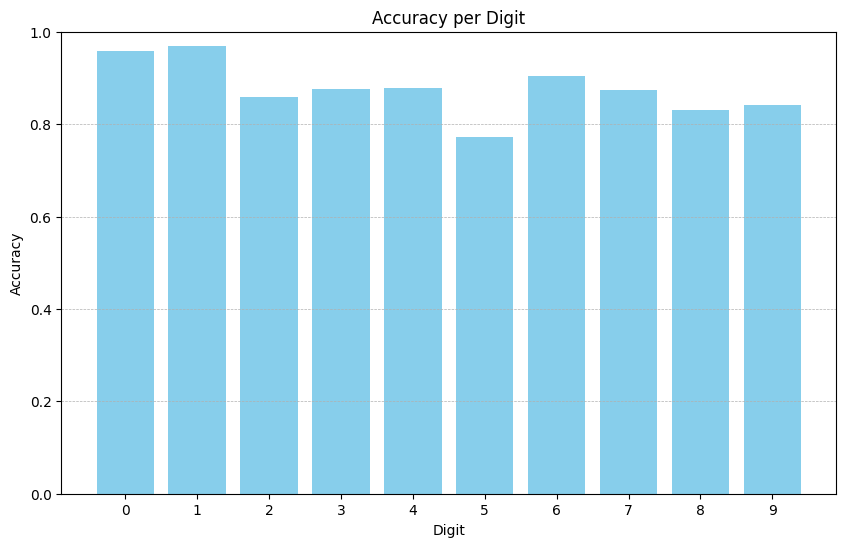

In [36]:
import matplotlib.pyplot as plt

classes = np.unique(y_test)
accuracy_per_class = {}

for cls in classes:
    idx = (y_test == cls)
    cls_accuracy = np.mean(predictions[idx] == y_test[idx])
    accuracy_per_class[cls] = cls_accuracy

# Plotting accuracy per digit
plt.figure(figsize=(10,6))
plt.bar(accuracy_per_class.keys(), accuracy_per_class.values(), color='skyblue')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Accuracy per Digit')
plt.xticks(classes)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

## Store the model

In [37]:
STORE = True

import numpy as np

# Function to save the model parameters to a file
def save_model(W1, b1, W2, b2, path):
    np.savez(path, W1=W1, b1=b1, W2=W2, b2=b2)
    print(f"Model saved to {path}")

# Function to load the model parameters from a file
def load_model(path):
    data = np.load(path)
    W1 = data['W1']
    b1 = data['b1']
    W2 = data['W2']
    b2 = data['b2']
    print(f"Model loaded from {path}")
    return W1, b1, W2, b2

# Specify the path where you want to save the model
MODEL_PATH = DATA_PATH + 'model_parameters.npz'  # You can change this to your desired path

if STORE:
    # Save the model parameters
    save_model(W1, b1, W2, b2, MODEL_PATH)


Model saved to ../data/mnist/model_parameters.npz


In [38]:
# To load the model later, use the load_model function
W1_loaded, b1_loaded, W2_loaded, b2_loaded = load_model(MODEL_PATH)

# Verify that the loaded parameters are the same as the original
assert np.array_equal(W1, W1_loaded), "W1 does not match!"
assert np.array_equal(b1, b1_loaded), "b1 does not match!"
assert np.array_equal(W2, W2_loaded), "W2 does not match!"
assert np.array_equal(b2, b2_loaded), "b2 does not match!"

# Use the loaded model to perform forward propagation on test data
Z1, A1, Z2, A2 = forward_prop(W1_loaded, b1_loaded, W2_loaded, b2_loaded, x_test.T)
print("Test accuracy after loading model:", get_accuracy(A2, y_test))

Model loaded from ../data/mnist/model_parameters.npz
Test accuracy after loading model: 0.878
